In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [2]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath("models")), '..'))

In [3]:
from models import rotTube

# Modèle Linéaire

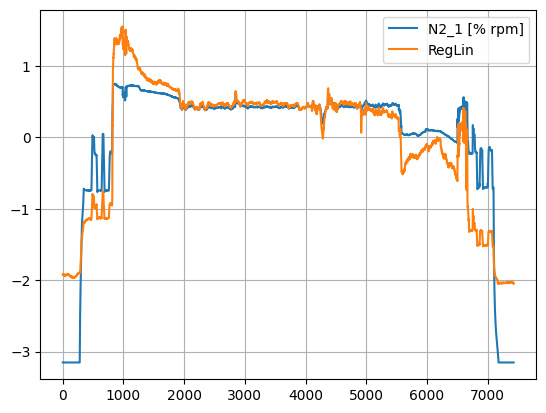

In [4]:
variableNames = ["N1_1 [% rpm]", "T1_1 [deg C]", "ALT [ft]", "M [Mach]"]
# X = ddf.partitions[0][variableNames].compute().values
f = open("../data_prepare/variables.npy", "rb")
X = np.load(f)
f.close()
Xnorm = (X - X.mean(axis=0)) / X.std(axis=0)
Xhat = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), Xnorm), axis=1)

targetName = ["N2_1 [% rpm]"]
# y = ddf.partitions[0][targetName].compute().values.reshape(-1, 1)
f = open("../data_prepare/target.npy", "rb")
y = np.load(f)
f.close()

yNorm = (y - y.mean(axis=0)) / y.std(axis=0)

aHat = np.linalg.solve(np.matmul(Xhat.transpose(), Xhat),
                       np.matmul(Xhat.transpose(), yNorm))
yHat = np.matmul(Xhat, aHat)


plt.figure()
plt.plot(yNorm, label=targetName[0])
plt.plot(yHat, label="RegLin")
plt.legend()
plt.grid("on")
plt.show()


In [5]:
tX = torch.Tensor(Xnorm)
ty = torch.Tensor(yNorm)
tyHat = torch.Tensor(yHat)

print("tX.shape : ", tX.shape)
print("ty.shape : ", ty.shape)
print("tyHat.shape :", tyHat.shape)

tX.shape :  torch.Size([7429, 4])
ty.shape :  torch.Size([7429, 1])
tyHat.shape : torch.Size([7429, 1])


In [6]:
# Hypperparamètres
N = 2000
lmax = 6
P0 = 0.1
epsilon = 0.01
fact = 0.8
sigma_0 = (lmax + 1) * fact
ns = [4,1]

# Temperature initiale
Temp = 0.05

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

args = {"N" : N, "lmax" : lmax, "ns" : ns, "P0" : P0, 
        "epsilon" : epsilon, "fact" : fact, "sigma_0" : sigma_0,
        "Temp" : Temp, "pdist" : pdist}

In [7]:
myModel = rotTube.resLin(4, 1)

In [8]:
thetas, rhoMin, epsJ, rhoMax = rotTube.trainBNN(args, tX, ty, myModel)

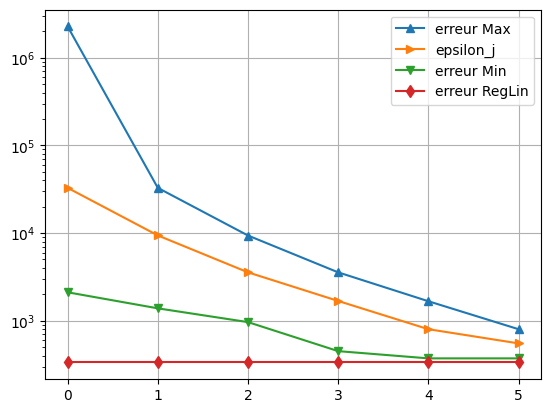

In [9]:
rhoFloor = torch.ones(lmax) *  (torch.cdist(ty.t(), tyHat.t(), p=pdist) ** 2) / rotTube.modelSize(ns)
plt.figure()
plt.plot(np.float32(rhoMax), label = 'erreur Max', marker = '^')
plt.plot(np.float32(epsJ), label = 'epsilon_j', marker = '>')
plt.plot(np.float32(rhoMin), label = 'erreur Min', marker = 'v')
plt.plot(rhoFloor.t(), label = 'erreur RegLin', marker = 'd')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

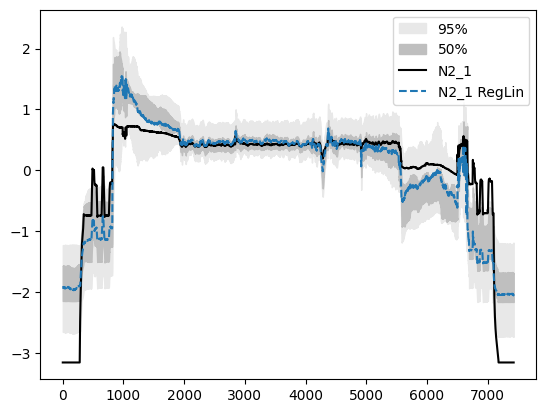

In [10]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)
q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()
plt.clf()


plt.fill_between(np.arange(ty.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(ty.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

# plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(ty, label='N2_1', color = 'k')

plt.plot(tyHat, label="N2_1 RegLin", linestyle='dashed')

plt.legend()
plt.show()


In [11]:
thetaRavel = torch.concatenate(tuple([torch.concatenate(tuple([p.ravel() for p in theta])).reshape(-1,1) for theta in thetas]), 1)

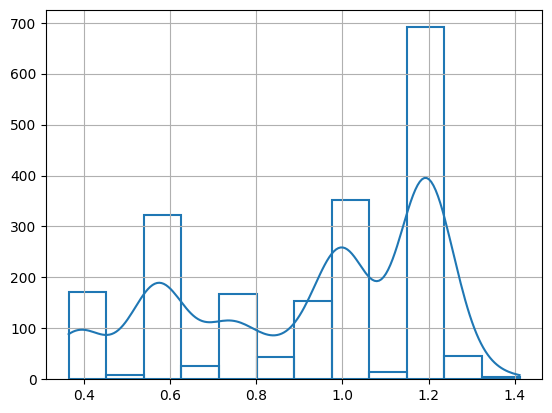

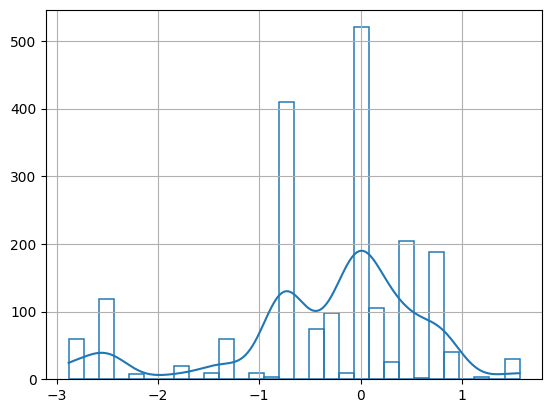

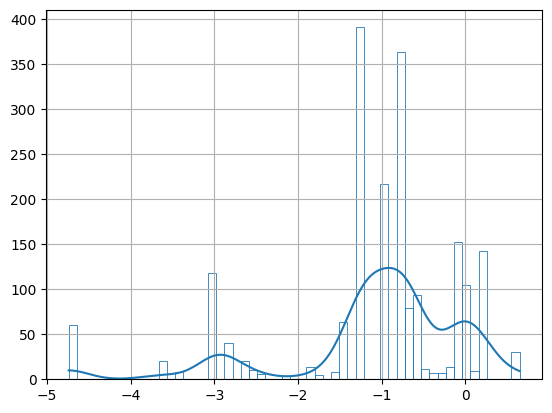

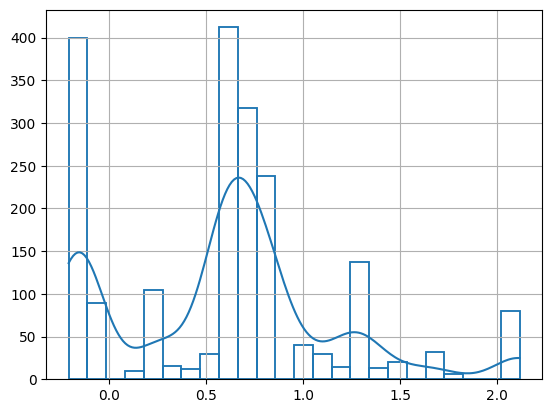

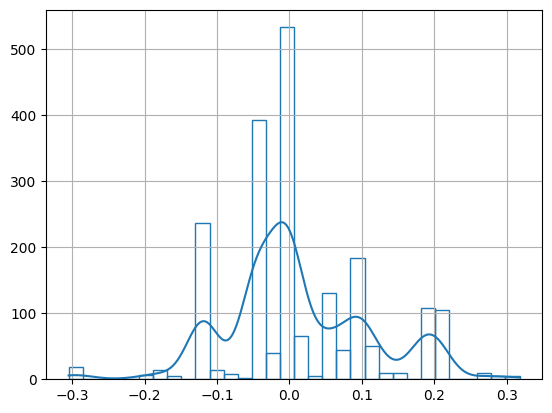

In [12]:
for k in range(thetaRavel.shape[0]) :
    plt.figure()
    sns.histplot(thetaRavel[k,:].detach().numpy(), kde = True, fill = False)
    plt.grid('on')
    plt.ylabel(None)

<Figure size 640x480 with 0 Axes>

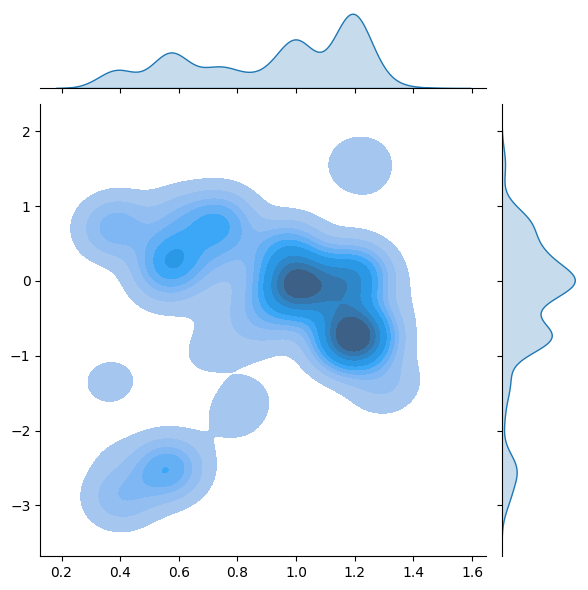

In [13]:
plt.figure()
s = 0
d = 1
sns.jointplot(x = thetaRavel[s,:].detach().numpy(), y = thetaRavel[d,:].detach().numpy(), kind='kde', fill=True)
plt.show()

# Modèle Réseau de neurones 4-2-1

In [14]:
# Hypperparamètres
N = 5000
lmax = 6
P0 = 0.1
epsilon = 0.01
fact = 0.5
sigma_0 = (lmax + 1) * fact
ns = [4,2,1]
# Temperature initiale
Temp = 1

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

args = {"N" : N, "lmax" : lmax, "ns" : ns, "P0" : P0, 
        "epsilon" : epsilon, "fact" : fact, "sigma_0" : sigma_0,
        "Temp" : Temp, "pdist" : pdist}

In [15]:
myModel = rotTube.resNet(4, 1)

In [16]:
thetas, rhoMin, epsJ, rhoMax = rotTube.trainBNN(args, tX, ty, myModel)

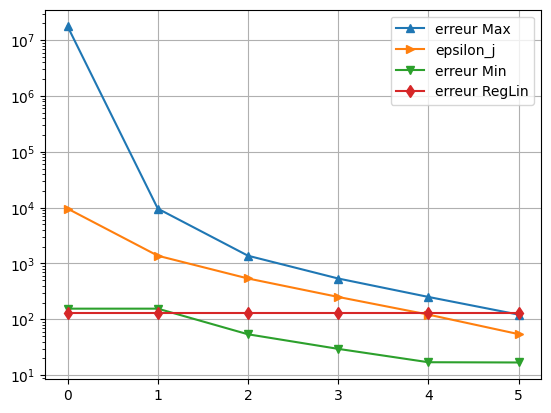

In [17]:
rhoFloor = torch.ones(lmax) *  (torch.cdist(ty.t(), tyHat.t(), p=pdist) ** 2) / rotTube.modelSize(ns)
plt.figure()
plt.plot(np.float32(rhoMax), label = 'erreur Max', marker = '^')
plt.plot(np.float32(epsJ), label = 'epsilon_j', marker = '>')
plt.plot(np.float32(rhoMin), label = 'erreur Min', marker = 'v')
plt.plot(rhoFloor.t(), label = 'erreur RegLin', marker = 'd')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

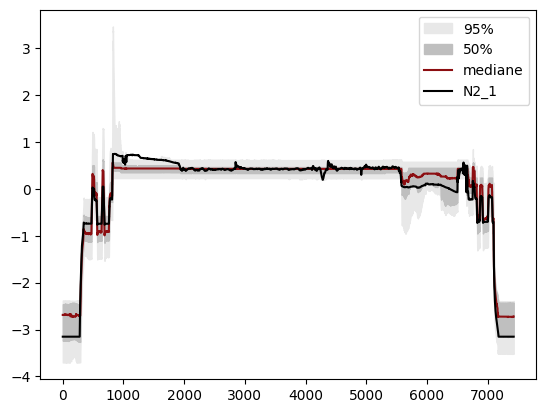

In [18]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)
q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()
plt.clf()
plt.fill_between(np.arange(ty.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(ty.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(ty, label='N2_1', color = 'k')

# plt.plot(tyHat, label="N2_1 RegLin", linestyle='dashed')

plt.legend()
plt.show()

In [19]:
thetaRavel = torch.concatenate(tuple([torch.concatenate(tuple([p.ravel() for p in theta])).reshape(-1,1) for theta in thetas]), 1)

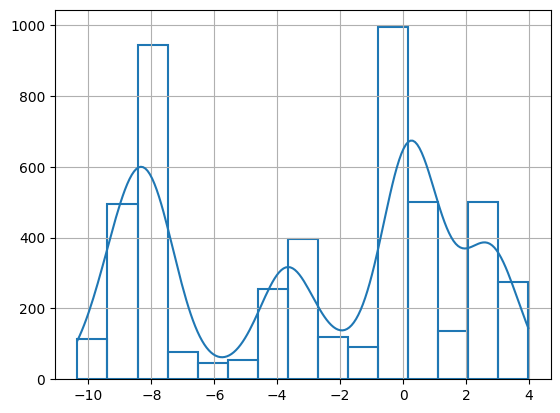

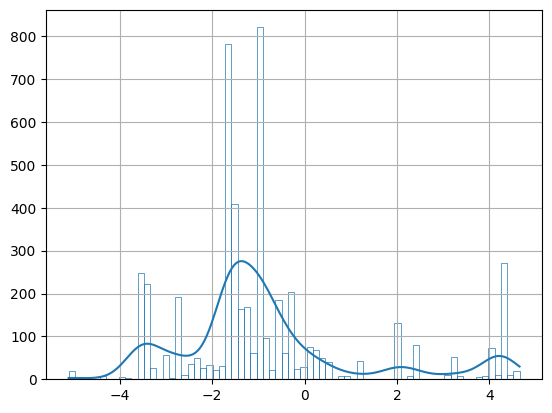

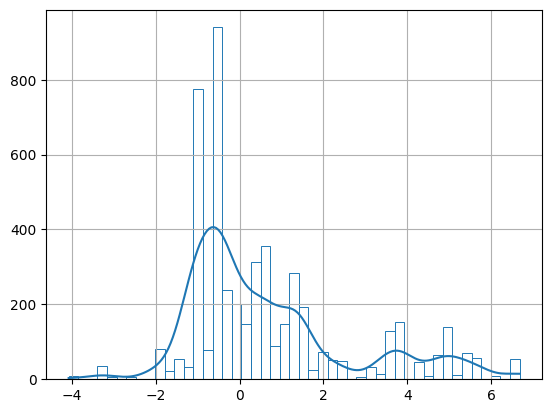

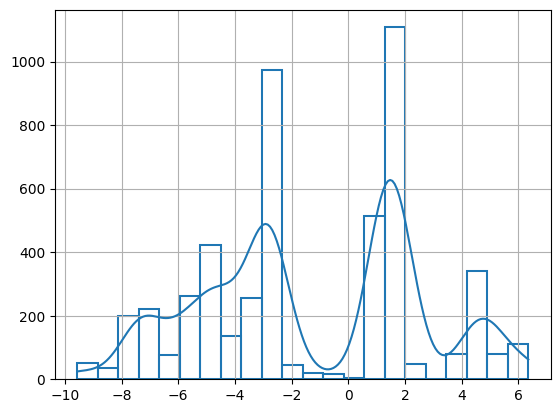

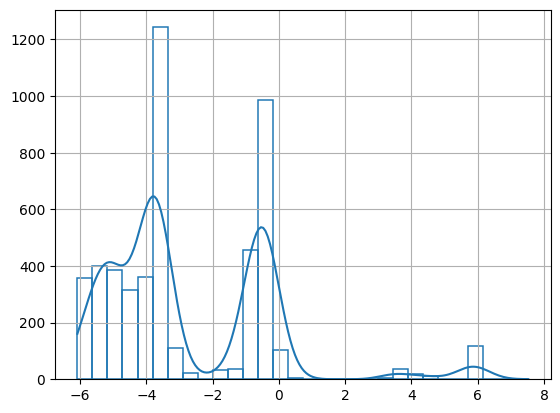

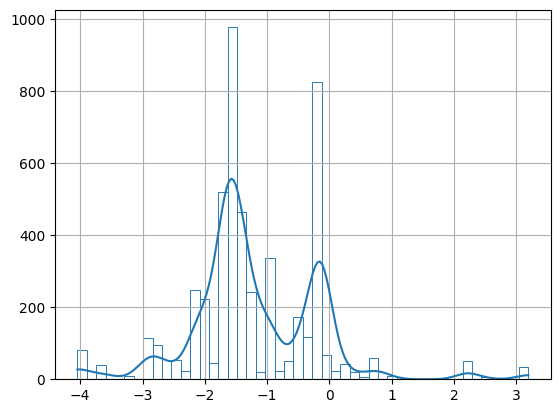

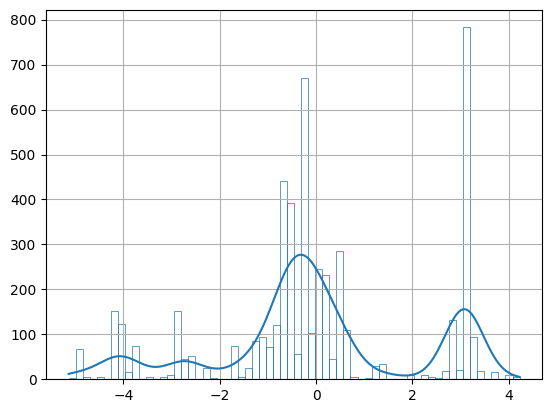

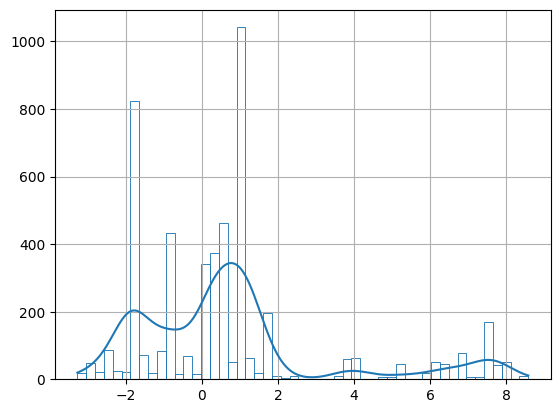

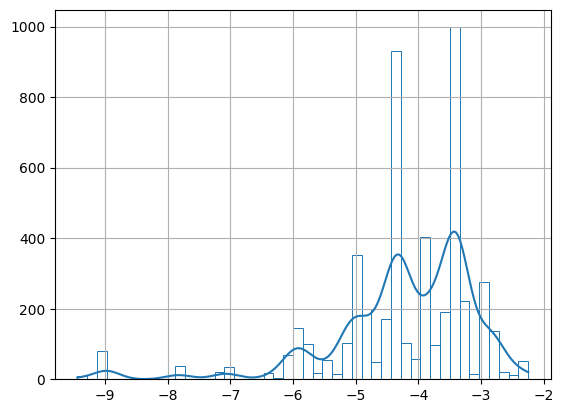

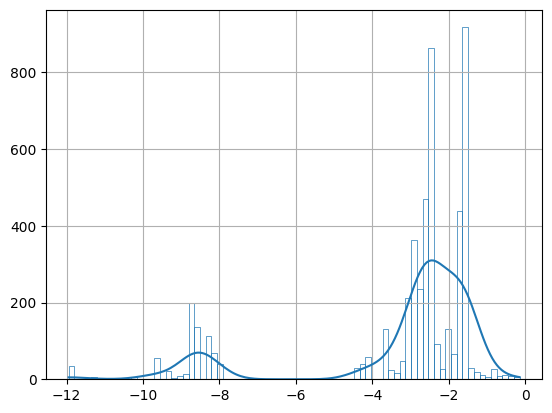

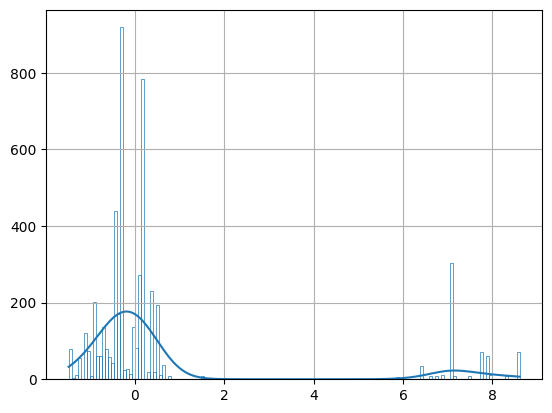

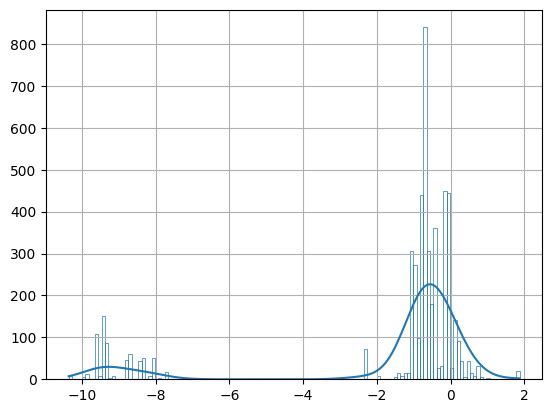

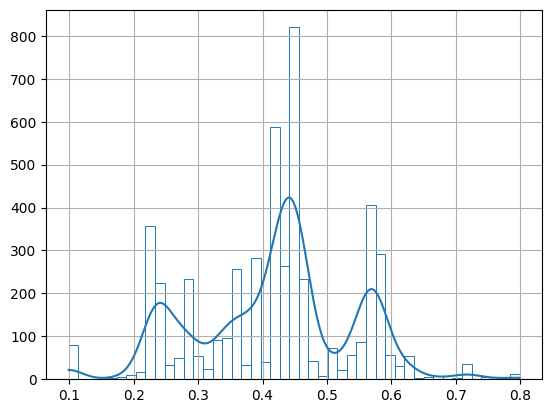

In [20]:
for k in range(thetaRavel.shape[0]) :
    plt.figure()
    sns.histplot(thetaRavel[k,:].detach().numpy(), kde = True, fill = False)
    plt.grid('on')
    plt.ylabel(None)

<Figure size 640x480 with 0 Axes>

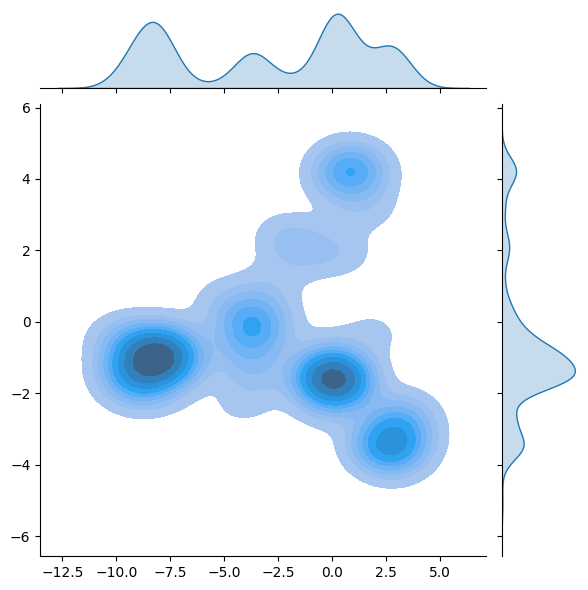

In [21]:
plt.figure()
s = 0
d = 1
sns.jointplot(x = thetaRavel[s,:].detach().numpy(), y = thetaRavel[d,:].detach().numpy(), kind='kde', fill=True)
plt.show()

In [22]:
tX.shape

torch.Size([7429, 4])

In [23]:
ty.shape

torch.Size([7429, 1])